In [1]:
import numpy as np 
from PIL import Image ,ImageDraw, ImageFont
from object_detection.YOLO_model import YOLOInference
from utils.crop_images import crop_image 
from Siamease_model.siamease_model_inference import get_image_similarity_onnx
from moviepy.editor import ImageSequenceClip
from collections import namedtuple
from Siamease_model.siamease_model_inference import get_image_similarity_onnx
from utils.pari_wise_comparison import get_pairwise_list
import copy 
import os
import re

#### Check the frames generated from the split video funciton 

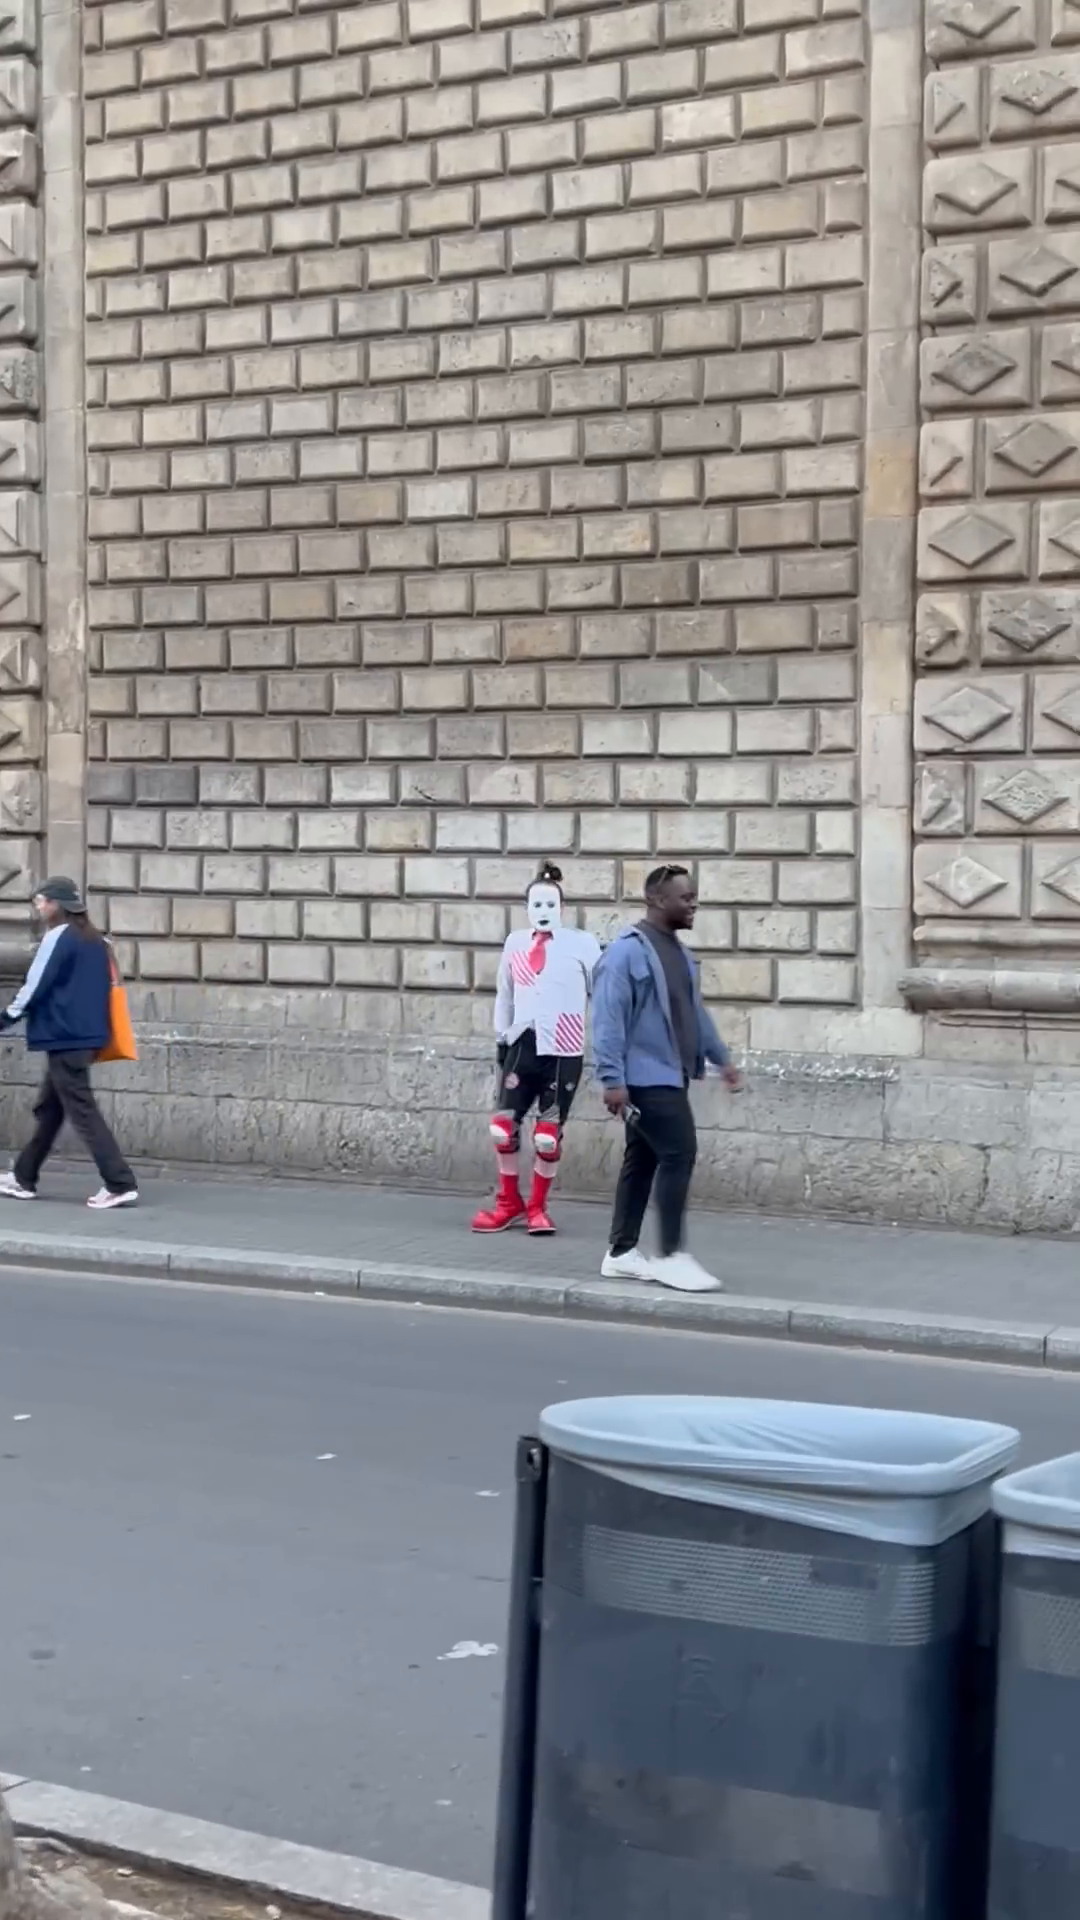

In [2]:
np_image = np.load('numpy_image_path')
image = Image.fromarray(np_image)
image

In [3]:
YOLO_MODEL = YOLOInference() 

In [ ]:

def extract_number(file_path):
    # Extract the number from the file name using regular expression
    match = re.search(r'frame_(\d+)\.npy$', file_path)
    if match:
        return int(match.group(1))
    else:
        return -1 

def get_file_paths(directory):
    file_paths = []

    # Walk through all files and directories in the given directory
    for root, directories, files in os.walk(directory):
        for file in files:
            # Join the root path with the file name to get the full file path
            file_path = os.path.join(root, file)
            file_paths.append(file_path)

    return file_paths

# Example usage:
directory = "numpy_frame_path"
frame_paths = get_file_paths(directory)
sorted_paths = sorted(frame_paths, key=extract_number)
print(sorted_paths)


['C:\\Users\\oshen geenath\\Desktop\\ai-tracker\\orel-ai-tracker-inference\\frames\\numpy_frames\\frame_0.npy', 'C:\\Users\\oshen geenath\\Desktop\\ai-tracker\\orel-ai-tracker-inference\\frames\\numpy_frames\\frame_1.npy', 'C:\\Users\\oshen geenath\\Desktop\\ai-tracker\\orel-ai-tracker-inference\\frames\\numpy_frames\\frame_2.npy', 'C:\\Users\\oshen geenath\\Desktop\\ai-tracker\\orel-ai-tracker-inference\\frames\\numpy_frames\\frame_3.npy', 'C:\\Users\\oshen geenath\\Desktop\\ai-tracker\\orel-ai-tracker-inference\\frames\\numpy_frames\\frame_4.npy', 'C:\\Users\\oshen geenath\\Desktop\\ai-tracker\\orel-ai-tracker-inference\\frames\\numpy_frames\\frame_5.npy', 'C:\\Users\\oshen geenath\\Desktop\\ai-tracker\\orel-ai-tracker-inference\\frames\\numpy_frames\\frame_6.npy', 'C:\\Users\\oshen geenath\\Desktop\\ai-tracker\\orel-ai-tracker-inference\\frames\\numpy_frames\\frame_7.npy', 'C:\\Users\\oshen geenath\\Desktop\\ai-tracker\\orel-ai-tracker-inference\\frames\\numpy_frames\\frame_8.npy', 

In [5]:
cropped_images_list = []
for index , i in enumerate(sorted_paths):
    yolo_ouput = YOLO_MODEL.run_inference(image_path=i , show_inference_time=False)

    # start bounding box filteration - TEMPORARY 
    # filter to get only bounding boxes/scores where the class is 0 
    # This can be remove in the future when the only class returned is 0. 
    filtered_bounding_box = [box for box, cls in zip(yolo_ouput.bounding_box, yolo_ouput.classes) if cls == 0]
    filtered_scores = [score for score, cls in zip(yolo_ouput.probability, yolo_ouput.classes) if cls == 0]
    # end of temporary code 

    crop = crop_image(image_path=i , bounding_boxes=filtered_bounding_box)

    cropped_images_list.append({"image_path":i , "crop_details":crop})
    # os.remove(i)

In [6]:
def Save_Frames_for_video_Output(idx,cropped_images_list):
    image_array = np.load(cropped_images_list[idx]['crop_details'].image_path)
    image = Image.fromarray(image_array)

    bounding_boxes = cropped_images_list[idx]['crop_details'].bounding_boxes
    id = cropped_images_list[idx]['crop_details'].id

    for b_id,box in zip(id,bounding_boxes):    
        x1, y1, x2, y2 = box
        draw = ImageDraw.Draw(image)
        draw.rectangle([x1, y1, x2, y2], outline="black", width=4)
        font = ImageFont.load_default(size=40)
        draw.text((x1+10, y1-45), f"{b_id}", fill="red" , font=font)

    #Numpy image save path
    image.save(f"C:\\Users\\oshen geenath\\Desktop\\ai-tracker\\orel-ai-tracker-inference\\frames\\frames_for_video_output\\output{idx}_numpy.png")
   

In [2]:
def recreate_video_from_frames(frames_directory, output_video_path, fps=30):
 
    frame_files = [f for f in os.listdir(frames_directory) if f.endswith('.png')]
    
    frame_files.sort(key=lambda f: int(re.search(r'\d+', f).group()))
    
    frame_files = [os.path.join(frames_directory, f) for f in frame_files]
    print(fps)
    
    video_clip = ImageSequenceClip(frame_files, fps=fps)
    video_clip.write_videofile(output_video_path, codec='libx264')

In [8]:
def display_image_with_id(reference_image, title=None, figsize=(8, 8)):
    img = reference_image['image']
    img_id = reference_image['id']
    
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"ID: {img_id}")
    if title:
        plt.title(title)
    plt.show()

In [9]:
import matplotlib.pyplot as plt

def display_images_with_text(image_list, text_list=None, titles=None, figsize=(15, 8)):
    """
    Display a list of images stored as numpy arrays horizontally using Matplotlib,
    with optional text labels and titles.

    Parameters:
        image_list (list): A list of numpy arrays representing images.
        text_list (list): Optional. A list of text labels corresponding to each image.
        titles (list): Optional. A list of titles corresponding to each image.
        figsize (tuple): Optional. A tuple specifying the figure size. Default is (15, 5).
    """
    num_images = len(image_list)
    fig, axes = plt.subplots(1, num_images, figsize=figsize)

    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    for i in range(num_images):
        axes[i].imshow(image_list[i], cmap='gray')
        axes[i].axis('off')
        if text_list:
            axes[i].text(0.5, 0.5, text_list[i], horizontalalignment='center', verticalalignment='center', fontsize=15, color='white', transform=axes[i].transAxes)
        if titles:
            axes[i].set_title(titles[i] if i < len(titles) else f"Image {i+1}")

    plt.tight_layout()
    plt.show()

In [10]:
copy_cropped_images_list = copy.deepcopy(cropped_images_list)

In [11]:
i = 0 
j = 1
ReferenceImages = []
for k in range (len(copy_cropped_images_list[0]['crop_details'].id)) :
    ReferenceImages.append({"image" : copy_cropped_images_list[0]['crop_details'].cropped_image[k] ,"id" : copy_cropped_images_list[0]['crop_details'].id[k]})

while j < 1240:
      
    index_list1 = [n for n in range(len(copy_cropped_images_list[i]['crop_details'].id))]
    index_list2 = [n for n in range(len(copy_cropped_images_list[j]['crop_details'].id))]
         
    for id2 in index_list2:
        
        jth_cropped_image = copy_cropped_images_list[j]['crop_details'].cropped_image[id2]
        jth_id  = copy_cropped_images_list[j]['crop_details'].id[id2]
        min = 1
        last_id = jth_id
    
        for id1 in index_list1:

            ith_cropped_image = copy_cropped_images_list[i]['crop_details'].cropped_image[id1]

            similarity_score = get_image_similarity_onnx(image_path1=ith_cropped_image , image_path2=jth_cropped_image)
                
            ith_id = copy_cropped_images_list[i]['crop_details'].id[id1]
            
            if similarity_score < min :

                copy_cropped_images_list[j]['crop_details'].id[id2] = ith_id
                min = similarity_score
                last_id = ith_id


        if min > 0.3 :
            Rmin =1 
            for item in ReferenceImages:
                R_similarity_score = get_image_similarity_onnx(image_path1=item['image'] , image_path2=jth_cropped_image)

                if R_similarity_score < Rmin :
                    R_ID = item['id']
                    Rmin = R_similarity_score

            if last_id != R_ID :

                if Rmin < 0.8: 
                    copy_cropped_images_list[j]['crop_details'].id[id2] = R_ID

                else :
                    ReferenceImages.append({"image" : copy_cropped_images_list[j]['crop_details'].cropped_image[id2] ,"id" : copy_cropped_images_list[j]['crop_details'].id[id2]})

        
    i = i + 1 
    j = i + 1 

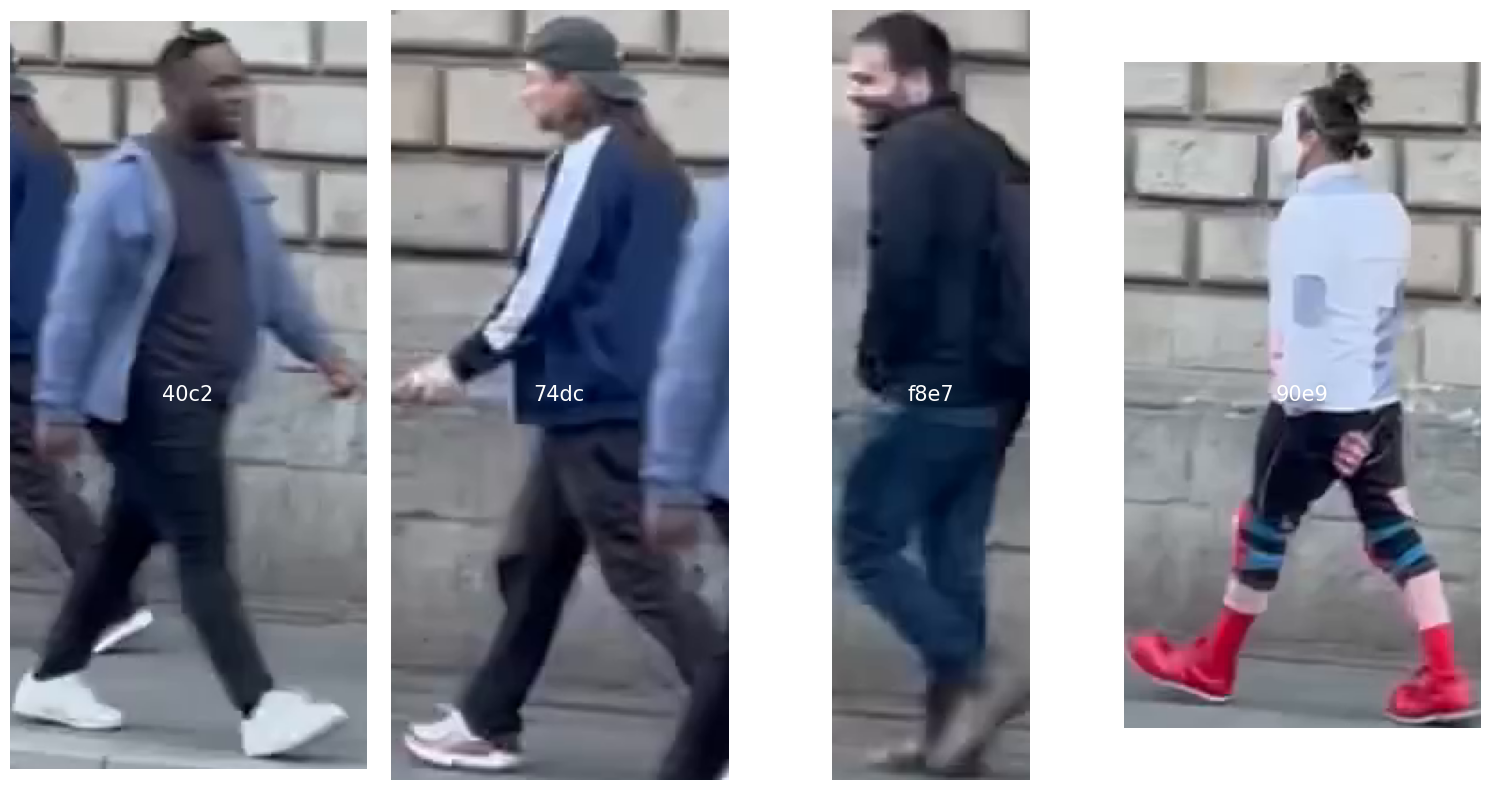

In [12]:
display_images_with_text(copy_cropped_images_list[0]['crop_details'].cropped_image , text_list=copy_cropped_images_list[0]['crop_details'].id)

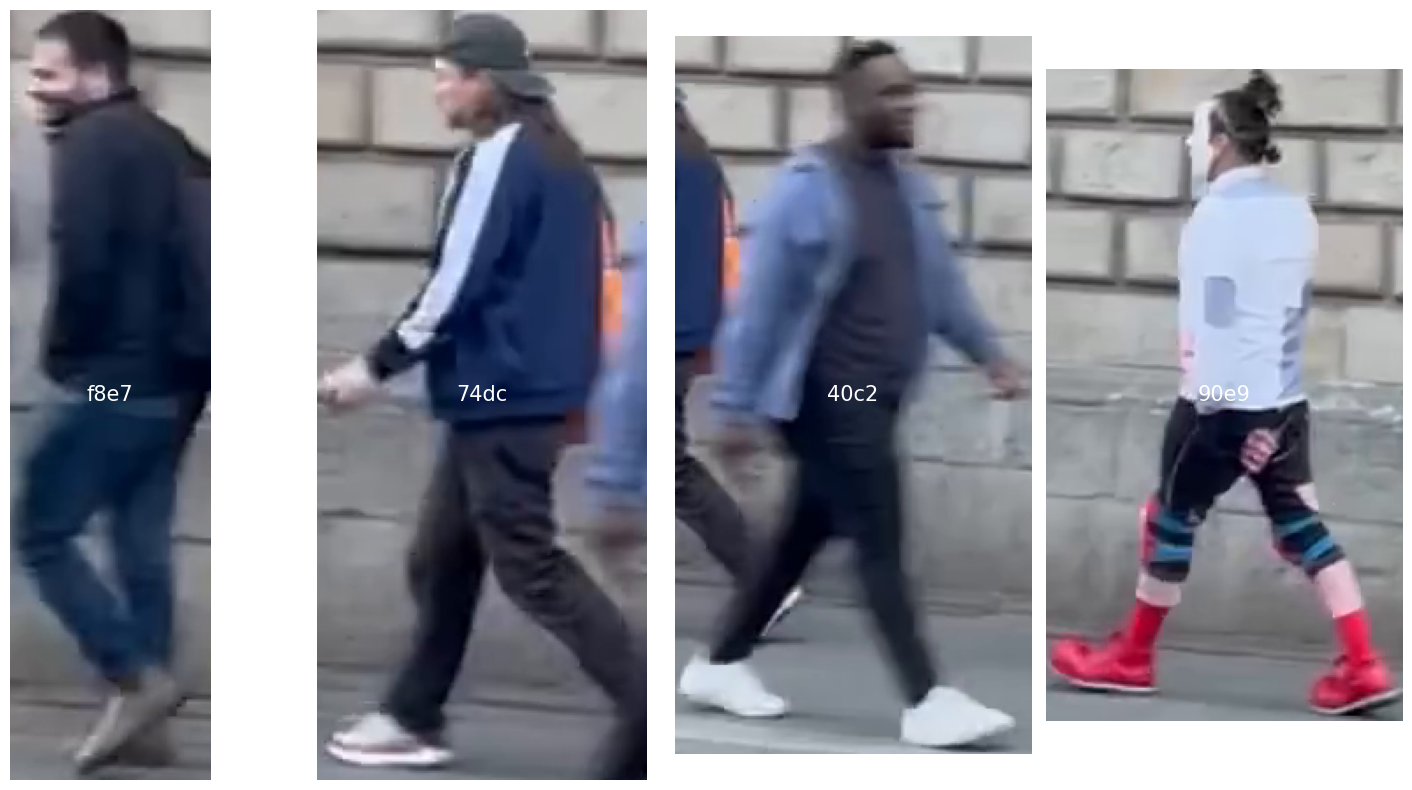

In [13]:
display_images_with_text(copy_cropped_images_list[1]['crop_details'].cropped_image , text_list=copy_cropped_images_list[1]['crop_details'].id)

In [14]:
for i in range(1240):
    Save_Frames_for_video_Output(i,copy_cropped_images_list)

In [3]:
recreate_video_from_frames(frames_directory="output_frames_path", output_video_path="output_video_path", fps=30)

30
Moviepy - Building video C:\Users\oshen geenath\Desktop\ai-tracker\orel-ai-tracker-inference\output_video_path\output1.mp4.
Moviepy - Writing video C:\Users\oshen geenath\Desktop\ai-tracker\orel-ai-tracker-inference\output_video_path\output1.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\oshen geenath\Desktop\ai-tracker\orel-ai-tracker-inference\output_video_path\output1.mp4
